In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/siim-medical-images/full_archive.npz
/kaggle/input/siim-medical-images/overview.csv
/kaggle/input/siim-medical-images/dicom_dir/ID_0015_AGE_0061_CONTRAST_1_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0019_AGE_0070_CONTRAST_1_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0063_AGE_0073_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0077_AGE_0074_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0073_AGE_0074_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0060_AGE_0080_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0051_AGE_0063_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0091_AGE_0072_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0004_AGE_0056_CONTRAST_1_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0076_AGE_0068_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images/dicom_dir/ID_0055_AGE_0071_CONTRAST_0_CT.dcm
/kaggle/input/siim-medical-images

In [14]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/siim-medical-images/overview.csv')

# Print the column names to check for 'image_filename'
print(df.columns)

Index(['Unnamed: 0', 'Age', 'Contrast', 'ContrastTag', 'raw_input_path', 'id',
       'tiff_name', 'dicom_name'],
      dtype='object')


In [16]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import pydicom 

# Load the dataset
data_dir = '/kaggle/input/siim-medical-images'
df = pd.read_csv(os.path.join(data_dir, 'overview.csv'))

# Preprocess the labels
y_contrast = LabelEncoder().fit_transform(df['Contrast'])
y_age = df['Age']

# Load and preprocess images
image_data = []
dicom_image_folder = os.path.join(data_dir, 'dicom_dir')

for filename in df['dicom_name']:
    image_path = os.path.join(dicom_image_folder, filename)

    if os.path.exists(image_path):
        dicom_data = pydicom.dcmread(image_path)
        image = dicom_data.pixel_array
        image = tf.image.convert_image_dtype(image, tf.float32)

        # Add channel dimension for single-channel images
        image = tf.expand_dims(image, axis=-1)

        # Resize the image to (224, 224)
        image = tf.image.resize(image, (224, 224))

        image_data.append(image)
    else:
        print(f"File not found: {image_path}")


X = np.array(image_data)

# Split the data into training and testing sets
X_train, X_test, y_contrast_train, y_contrast_test, y_age_train, y_age_test = train_test_split(
    X, y_contrast, y_age, test_size=0.2, random_state=42)

# Build a CNN model for contrast prediction
model_contrast = keras.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: with and without contrast
])

# Compile the model for contrast prediction
model_contrast.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model for contrast prediction
history_contrast = model_contrast.fit(X_train, y_contrast_train, epochs=10, validation_split=0.2)
model_contrast.fit(X_train, y_contrast_train, epochs=10, validation_split=0.2)
# Build a CNN model for age prediction
model_age = keras.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Regression for age prediction
])

# Compile the model for age prediction
model_age.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model for age prediction
history_age = model_age.fit(X_train, y_age_train, epochs=10, validation_split=0.2)
model_age.fit(X_train, y_age_train, epochs=10, validation_split=0.2)

# Predict contrast usage on the test set
y_contrast_pred = model_contrast.predict(X_test)

# Predict age on the test set
y_age_pred = model_age.predict(X_test)


Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 0.7604 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.6250
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 0.6943 - accuracy: 0.5469 - val_loss: 0.6971 - val_accuracy: 0.3750
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6959 - val_accuracy: 0.3750
Epoch 4/10
2/2 [==============================] - 4s 2s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.3750
Epoch 5/10
2/2 [==============================] - 4s 2s/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6951 - val_accuracy: 0.3750
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6980 - val_accuracy: 0.3750
Epoch 8/10
2/2 [=========================

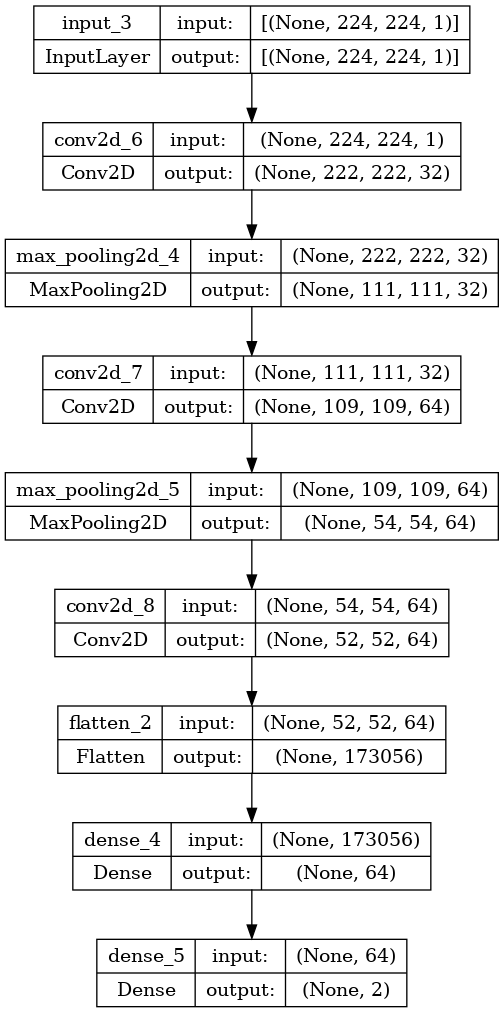

In [17]:
from keras.utils import plot_model

# Generate and save the model architecture diagram
plot_model(model_contrast, to_file='model_contrast.png', show_shapes=True)


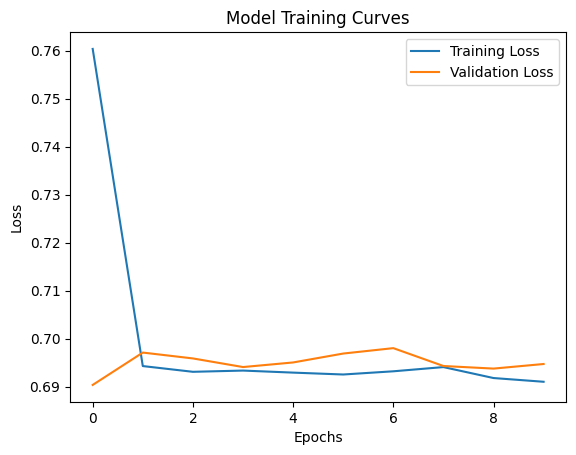

In [18]:
import matplotlib.pyplot as plt

# Collect training history
#history = model_contrast.fit(X_train, y_contrast_train, epochs=10, validation_split=0.2)

# Plot training and validation loss
plt.plot(history_contrast.history['loss'], label='Training Loss')
plt.plot(history_contrast.history['val_loss'], label='Validation Loss')
plt.title('Model Training Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 53ms/step


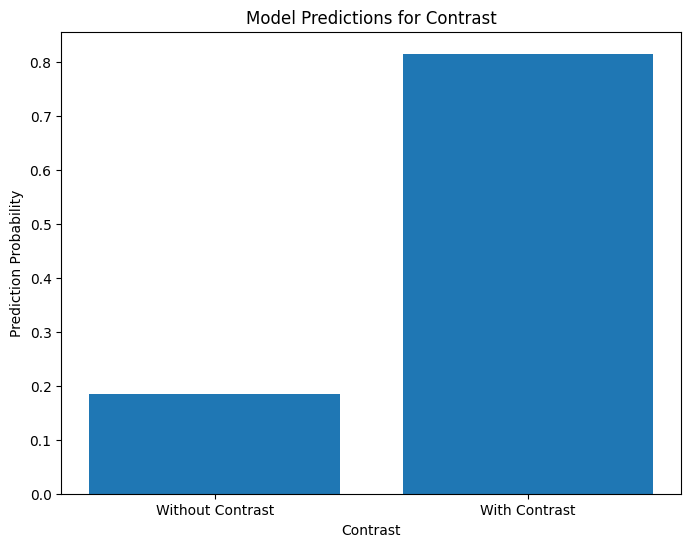

In [19]:
import random
import matplotlib.pyplot as plt

# Select a random sample from the test data
sample_index = random.randint(0, len(X_test))
sample_image = X_test[sample_index]
sample_ground_truth = y_contrast_test[sample_index]

# Get the model's prediction for this sample
sample_prediction = model_contrast.predict(sample_image.reshape(1, 224, 224, 1))

# Define class labels
class_labels = ['Without Contrast', 'With Contrast']

# Create a bar chart to visualize the model's predictions
plt.figure(figsize=(8, 6))
plt.bar(class_labels, sample_prediction[0])
plt.title('Model Predictions for Contrast')
plt.xlabel('Contrast')
plt.ylabel('Prediction Probability')
plt.show()


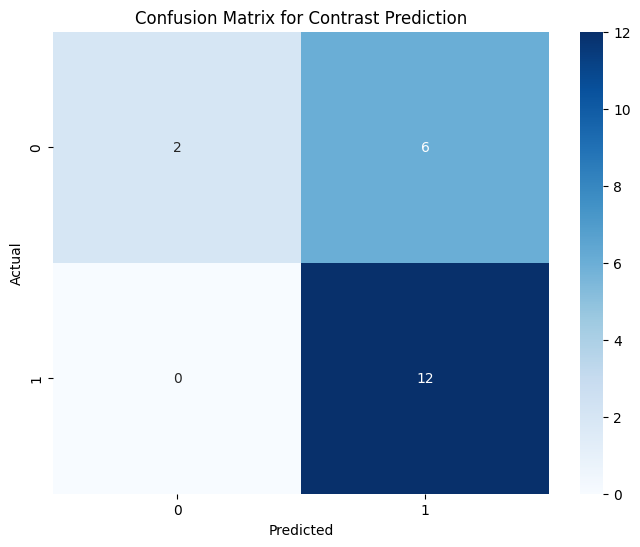

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.67      1.00      0.80        12

    accuracy                           0.70        20
   macro avg       0.83      0.62      0.60        20
weighted avg       0.80      0.70      0.64        20



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_contrast_pred, axis=1)

# Convert the numeric labels in y_contrast_test to strings
y_contrast_test = [str(label) for label in y_contrast_test]

# Convert the predicted labels to strings
y_pred_labels = [str(label) for label in y_pred_labels]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_contrast_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Contrast Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Create a classification report
print(classification_report(y_contrast_test, y_pred_labels))
